In [179]:
# Imports 
import os
import xml.etree.ElementTree as et
import pandas as pd
from itertools import chain

import numpy as np
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD as LSA
import random
random.seed(13)


#visualisation stuff
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline

import spacy
from collections import Counter
from spacy.tokenizer import Tokenizer
nlp = spacy.load('en')
tokenizer = Tokenizer(nlp.vocab)
import networkx as nx

In [2]:
# Load data 
PATH = "../xml/"
extension = ".xml"

def load_order(PATH, extension):
    """
    Custom function for loading and sorting the xml files from the TOTA dataset.
    Returns an array of filenames sorted by the number in the file name.
    """
    files = []
    for filename in os.listdir(PATH):
        if filename == ".ipynb_checkpoints":
            continue
        files.append(filename.split(".")[0]) # remove .xml
    files.sort(key=lambda x:int(x.split("_")[1])) # sort files based on file number 

    files = [file + extension for file in files]
#     print(files)
    return files

files = load_order(PATH, extension)

In [3]:
def xml2list(file):
    """
    Custom function for parsing and outputing the data into arrays.
    Returns two array's the extracted column names and content for each column.
    """
    parsed_xml = et.parse(file)

    root = parsed_xml.getroot()

    meta_column_names = []
    meta_column_content = []

    for item in root[0]:
        grandchild = item.findall(".//")
        if grandchild:
            grandstore = []
            #print(item.tag)
            meta_column_names.append(item.tag)
            for x in grandchild:
                grandstore.append(int(x.attrib.get('n')))
                #print(x.tag +":", x.attrib)
            meta_column_content.append(grandstore)

        else:
            #print(item.tag +":", item.text)
            meta_column_names.append(item.tag)
            meta_column_content.append(item.text)
            
    return meta_column_names, meta_column_content
    
    
def xml2list_text(file):
    """
    Custom function for parsing and outputing the data into arrays.
    Returns two array's the extracted column names and content for each column.
    """

    parsed_xml = et.parse(file)
    root = parsed_xml.getroot()
    chapters = []
    article_store = []
    
    treaty_text = ''
    
    for item in root[1]:
        chapter_name = item.attrib.get('name')
#         print("chapter: " + item.attrib.get('name'))
        chapters.append(chapter_name)
        if chapter_name == None:
            continue
        treaty_text += chapter_name + " "
        
        articles = item.findall("article")
        for article in articles:
#             print(article.attrib.get('name'))
            art_no = article.attrib.get('number')
            art_text =  article.text
            article_store.append(art_no)
            if art_no == None:
                continue
#             print(art_no)
            treaty_text += art_no + " "
            treaty_text += art_text + " "
        
            
    return len(chapters), len(article_store), treaty_text

In [4]:
textdf = pd.DataFrame()

chapter_numbers = []
article_numbers = []
treaty_text = []

for i in range(0, len(files)):
    chapter_no, article_no, text = xml2list_text(PATH + files[i])
    chapter_numbers.append(chapter_no)
    article_numbers.append(article_no)
    treaty_text.append(text.lower())

textdf["chapter_number"] = chapter_numbers
textdf["article_number"] = article_numbers
textdf["treaty_text"] = treaty_text

In [10]:
# with open('alltext.txt', 'w') as f:
#     for item in t_txt:
#         f.write("%s\n" % item)

In [7]:
with open("alltext.txt") as f:
    wordcount = Counter(f.read().split())

stop_words_law = []
for item, frequency in wordcount.most_common(2000):
    stop_words_law.append(item)
stop_words_law.append('\n')

In [8]:
dfcols, null = xml2list(PATH + files[3])
totadf = pd.DataFrame(columns=dfcols)

for i in range(0, len(files)):
    dfcolstmp, datatmp = xml2list(PATH + files[i])
    tmp_df = pd.DataFrame([datatmp], columns=dfcolstmp)
    tmp_df = tmp_df.loc[:,~tmp_df.columns.duplicated()] #very important! removes duplicate columns note that it removes the multiple "source" columnsns
    totadf = totadf.loc[:,~totadf.columns.duplicated()]#very important! removes duplicate columns note that it removes the multiple "source" columnsns 
    totadf = pd.concat([totadf,tmp_df], axis=0, sort=False)
totadf = totadf.reset_index(drop=True)
totadf = pd.concat([totadf, textdf], axis=1)

In [206]:
relations = totadf[totadf['status'] == "In Force"]

relations = relations[relations['crossregional'] == 'Yes'].region

new_relations = []
for i in relations:
    i = i.split("; ")
    new_relations.append(i)


uniquePairings = set(map(tuple,new_relations))


In [209]:
import csv

with open("output.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(str(relations))

In [211]:
my_df = pd.DataFrame(new_relations)

my_df.to_csv('my_csv.csv', index=False, header=False)

In [203]:
G=nx.Graph()
G.add_nodes_from(relations)
G.add_edges_from(list(uniquePairings))
fig=plt.figure(figsize=(13, 12))
pos = nx.spring_layout(G, scale=300,iterations=40, k=1)
nx.draw(G, pos, node_size=20,width=0.1, with_labels=True)

plt.show() # display

ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [11]:
totadf['year_signed'] = totadf.date_signed.map( lambda x: pd.to_datetime(x).year)
totadf = totadf[totadf.language == 'en']
new = ['treaty_identifier', 'chapter_number', 'article_number', 'treaty_text', 'year_signed', 'type']

totadf_emb = totadf[new]
totadf_emb = totadf_emb.reset_index()
totadf_emb.head()

,index,treaty_identifier,chapter_number,article_number,treaty_text,year_signed,type
0,0,1,17,175,preamble general provisions article 1 the obje...,2007,Free Trade Agreement & Economic Integration Ag...
1,1,2,8,40,preamble article 1 the parties shall gradually...,2005,Free Trade Agreement
2,2,3,21,201,preamble general provisions article 1 the part...,2007,Free Trade Agreement & Economic Integration Ag...
3,3,4,3,0,,2006,Free Trade Agreement
4,4,5,11,52,preamble general provisions article 1 1. egypt...,2007,Free Trade Agreement


In [133]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
def txt_2_emb(text_data):
    #I convert a collection of raw documents into a matrix of TF-IDF features
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=n_features, stop_words=stop_words_law)
    #retearns a term-document matrix
    tfidf = tfidf_vectorizer.fit_transform(text_data['treaty_text'])
    # This is where the non negative matrix factorization happens - in short it is a form of dimensionality reduction
    nmf = NMF(n_components=n_topics, random_state=0).fit(tfidf)

    # print("Topics found via LSA:")
    # need to print the words most related to the seperate topics - quite difficult to differentiate by hand. 
    # tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    # print_top_words(nmf, tfidf_feature_names, n_top_words)

    nmf_embedding = nmf.transform(tfidf)
    nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)
    return nmf_embedding

def create_dataframe(nmf_embedding, tsne, text_data):
    tsne_embedding = tsne.fit_transform(nmf_embedding) 
    tsne_embedding = pd.DataFrame(tsne_embedding, columns=['x','y']) # turn the results into a dataframe
    tsne_embedding['hue'] = nmf_embedding.argmax(axis=1) # attach a hue column so that we can later color each cluster differently
    tsne_embedding['year'] = text_data['year_signed'] # attach a year column so that we can see the evolution of the treaties over time.
    tsne_embedding['type'] = text_data['type']
    return tsne_embedding

In [134]:
list(totadf_emb.type.unique())

['Free Trade Agreement & Economic Integration Agreement',
 'Free Trade Agreement',
 'Customs Union',
 'Customs Union & Economic Integration Agreement',
 'Partial Scope Agreement',
 'Economic Integration Agreement']

In [135]:
# treaty_type = "Customs Union"
# text_data = totadf_emb[totadf_emb.type == treaty_type]
# text_data

In [150]:

n_features = 1000
n_topics = 7 # 5 because I want it to try and cluster based on the 5 treaty types
n_top_words = 3
tsne1 = TSNE(n_iter=5000,random_state=3211,learning_rate=100, perplexity=5) # run t-sne with the various parameters
tsne2 = TSNE(random_state=3211,learning_rate=100, perplexity=15) # run t-sne with the various parameters

def treaty_data(treaty_type, tsne):
    text_data = totadf_emb[totadf_emb.type == str(treaty_type)]
    text_data = text_data.reset_index()
    nmf_embedding = txt_2_emb(text_data)
#     print(text_data['type'].head())
    tsne_embedding = create_dataframe(nmf_embedding, tsne, text_data)
    return(tsne_embedding)

def all_data(tsne):
    text_data = totadf_emb
    nmf_embedding = txt_2_emb(text_data)
    tsne_embedding = create_dataframe(nmf_embedding, tsne, text_data)
    return(tsne_embedding)

FTA = treaty_data("Free Trade Agreement", tsne1)
FTA_ = treaty_data("Free Trade Agreement & Economic Integration Agreement",tsne2)
ALL = all_data(tsne1)
# CU = treaty_data("Customs Union",tsne)
# CU_ = treaty_data("Customs Union & Economic Integration Agreement",tsne)
# PSA = treaty_data("Partial Scope Agreement",tsne)
# EIA = treaty_data("Economic Integration Agreement",tsne)


In [151]:
# CU.head()

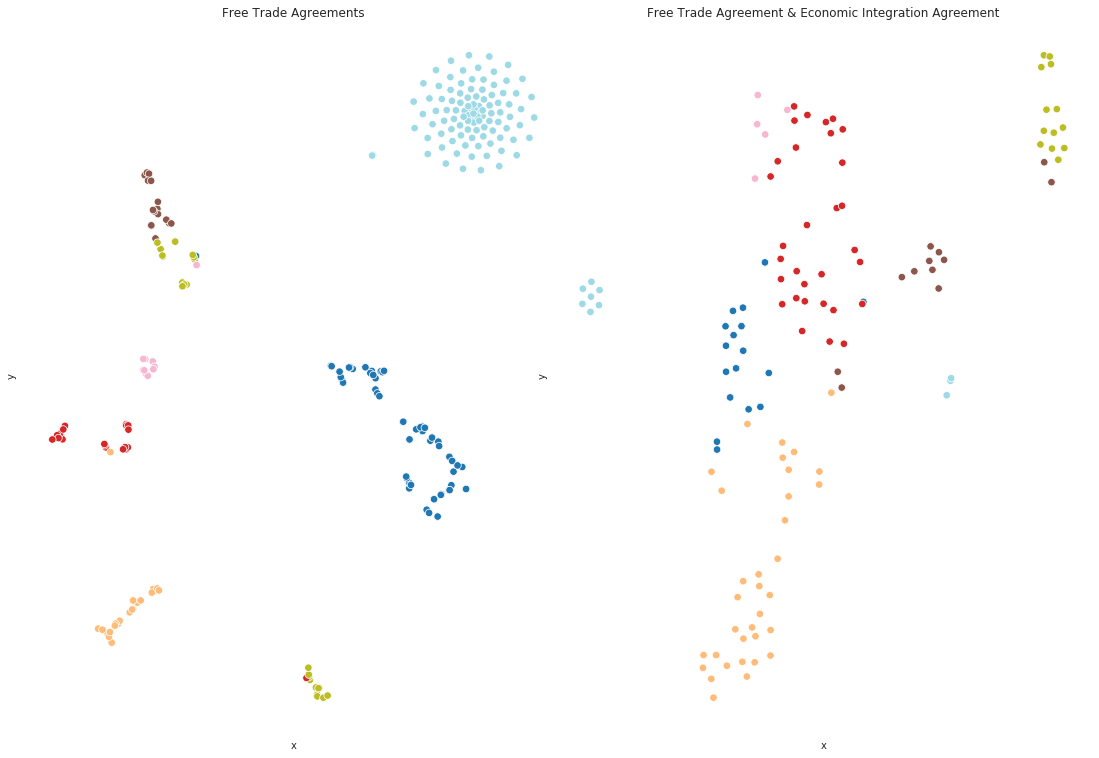

In [152]:
# color_list = plt.cm.viridis(np.linspace(0, 1, n_topics))

# legend_list = []

# for i in range(len(topics)):   
#     color = color_list[i]
#     legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))
sns.set_style("white")
fig, axs = plt.subplots(1,2,figsize=(19, 13), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

# for year, idx in zip([2016], range(1)):

#     tsne_embedding.to_csv("year_full.csv", sep=",")
size = 56
ax1 = sns.scatterplot(data=FTA,x='x',y='y',s=size,hue='hue', palette='tab20', ax=axs[0], label="Free Trade Agreements")
ax2 = sns.scatterplot(data=FTA_,x='x',y='y',s=size,hue='hue', palette='tab20', ax=axs[1], label="Free Trade Agreement & Economic Integration Agreement")

# axs.set_title('Treaties signed until {}'.format(year),**{'fontsize':'10'})

sns.despine(left=True, bottom=True)
ax1.set(yticklabels=[])
ax2.set(yticklabels=[])
ax1.set(xticklabels=[])
ax2.set(xticklabels=[])

ax1.set_title("Free Trade Agreements")
ax2.set_title("Free Trade Agreement & Economic Integration Agreement")

ax1.legend_.remove()
ax2.legend_.remove()
# fig.legend(legend_list, topics, loc=(0.2,0.89), ncol=5)

# plt.savefig('MOCUP.png', format='png', dpi=100, transparent=True)

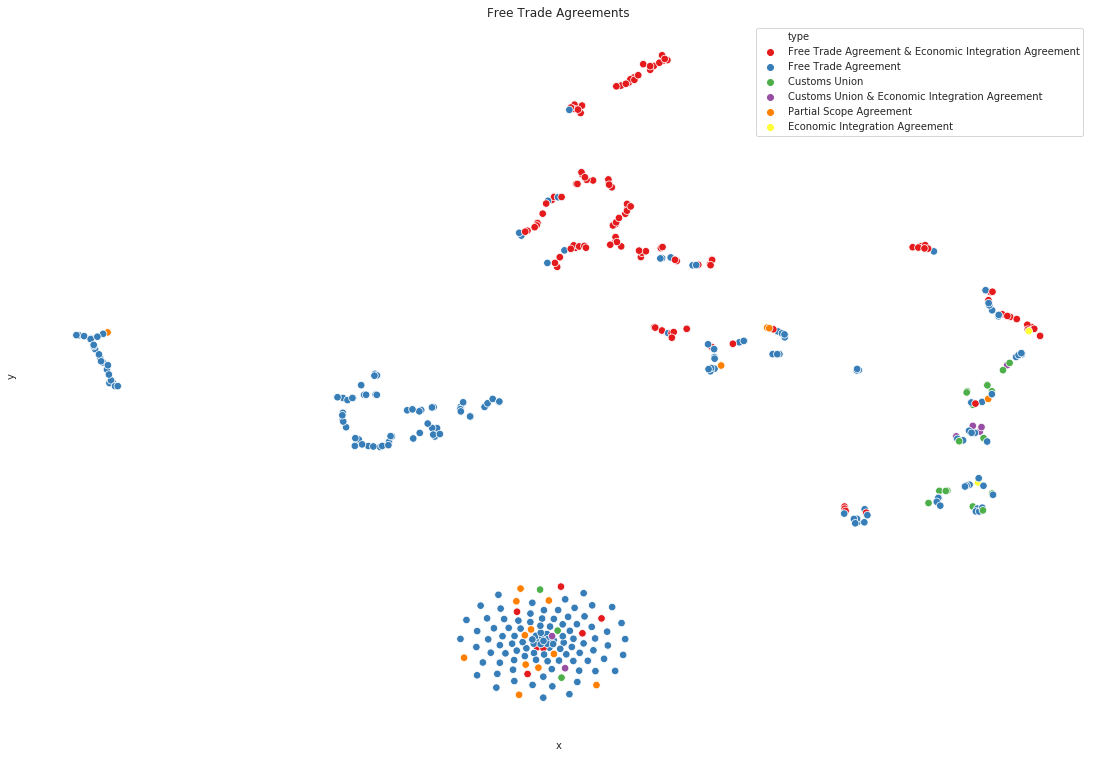

In [157]:
sns.set_style("white")
fig, axs = plt.subplots(figsize=(19, 13), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

# for year, idx in zip([2016], range(1)):

#     tsne_embedding.to_csv("year_full.csv", sep=",")
size = 56
ax1 = sns.scatterplot(data=ALL,x='x',y='y',s=size, hue='type', palette='Set1')

sns.despine(left=True, bottom=True)
ax1.set(yticklabels=[])
ax1.set(xticklabels=[])
ax1.set_title("Free Trade Agreements")



plt.savefig('MOCUP2.png', format='png', dpi=100, transparent=True)

In [197]:
# tsne_embedding.head()

,x,y,hue,year
0,5.248753,-14.089790,9,2007.0
1,1.545438,10.078738,4,2005.0
2,0.032933,-14.201297,0,2007.0
3,-2.382143,-2.954867,17,2006.0
4,2.006824,12.395350,11,2007.0


In [203]:
# tsne_embedding.loc[(tsne_embedding['hue'] == 0)]

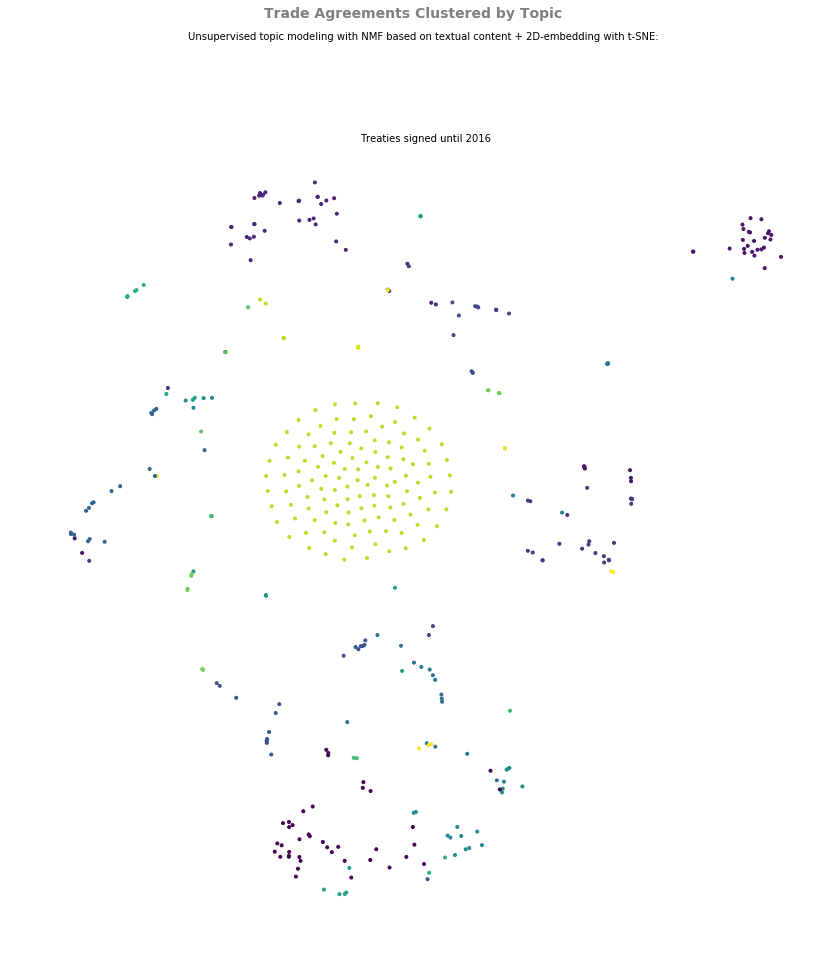

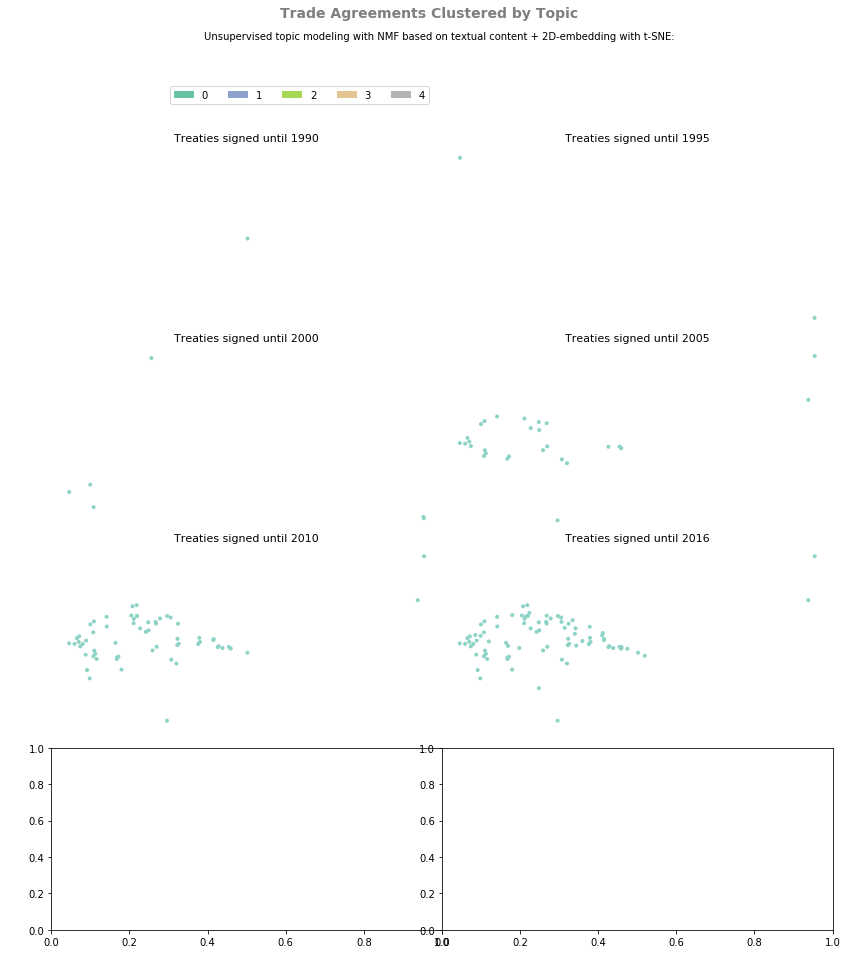

In [163]:
fig, axs = plt.subplots(ncols=2,nrows=4,figsize=(14, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

axs = axs.ravel()

for year, idx in zip([1990,1995,2000,2005,2010,2016], range(8)):
    data = tsne_embedding.loc[(totadf_emb['year_signed']<=year) &(tsne_embedding['hue'] == 0)]
    scatter = axs[idx].scatter(data=data,x='x',y='y',s=9,c=data['hue'], cmap='Set3')
    axs[idx].set_title('Treaties signed until {}'.format(year),**{'fontsize':'11'})
    axs[idx].axis('off')

plt.suptitle("Trade Agreements Clustered by Topic",**{'fontsize':'14','weight':'bold'}, alpha=0.5)
plt.figtext(.51,0.95,'Unsupervised topic modeling with NMF based on textual content + 2D-embedding with t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')


fig.legend(legend_list, topics, loc=(0.2,0.89), ncol=5)
plt.subplots_adjust(top=0.85)

# plt.savefig('ToTa.png', format='png', dpi=1000)